# Neural networks regression analysis using Keras

The code runs on the environment tflow and is based on the example in : https://medium.com/@rajatgupta310198/getting-started-with-neural-network-for-regression-and-tensorflow-58ad3bd75223

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

import matplotlib.pyplot as plt
import netCDF4 as n
%matplotlib inline
from utils import train_test_split

In [3]:
from tflow_reg import nn_model

# from tflow_reg_new import nn_model

## Import data

In [6]:
path = "./files/"
filenames = ["specific_humidity_Europa_sp.nc", "relative_humidity_Europa_sp.nc", "pressure_Europa_sp.nc",  
             "temperature_Europa_sp.nc", "total_cloud_cover_Europa_sp.nc"]


cloud = n.Dataset(path + filenames[-1], "r")
relative = n.Dataset(path + filenames[1], "r")
specific = n.Dataset(path + filenames[0], "r")
pressure = n.Dataset(path + filenames[2], "r")
temperature = n.Dataset(path + filenames[3], "r")

my_files = {'cloud':cloud, 'relative':relative, 'specific':specific, 'pressure':pressure, 'temperature':temperature}


tcc = cloud.variables["tcc"]
rh = relative.variables["r"]
q = specific.variables["q"]
sp = pressure.variables["sp"]
t2m = temperature.variables["t2m"]

my_vars = {'tcc':tcc, 'rh':rh, 'q':q, 'sp':sp, 't2m':t2m}

n_days = 2
n_grid_boxes = tcc.shape[1]*tcc.shape[2]
X = np.empty((n_grid_boxes*n_days*4, 4))
y = np.empty((n_grid_boxes*n_days*4))



for t in range(int(n_days*4)):
    i = 0
    for key, value in my_vars.items():
        if key == 'tcc':
            y[n_grid_boxes*t:n_grid_boxes*(t+1)] = np.array(value[t, : , :]).flatten()
        elif key == 'rh' or key == 'q':
            X[n_grid_boxes*t:n_grid_boxes*(t+1), i] = np.array(value[t, 0, : , :]).flatten()
            i = i+1
        else:
            X[n_grid_boxes*t:n_grid_boxes*(t+1), i] = np.array(value[t, : , :]).flatten()
            i=i+1

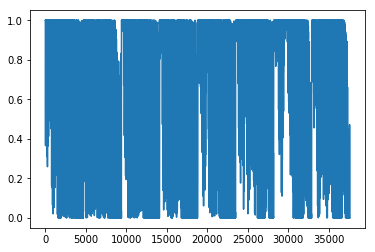

In [7]:

plt.plot(range(y.shape[0]),y,label="Original Data")

### Standarize and split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, split_size=0.2)

Xn_train = (X_train - X_train.mean(axis=0))/X_train.std(axis=0)
yn_train = (y_train - y_train.mean())/y_train.std()

Xn_test = (X_test - X_train.mean(axis=0))/X_train.std(axis=0)
yn_test = (y_test - y_train.mean())/y_train.std()

## Neural net model

Feed forward neural net with 2 layers. Activation function: Sigmoid for all layers.

### Run neural network model

In [12]:
npred = Xn_train.shape[1]
noutput = Xn_train.shape[0]
n_nodes = [npred, 100, 150, 1]

In [13]:
xs = tf.placeholder("float")
ys = tf.placeholder("float")

output = nn_model(xs, n_nodes)
#output = nn_model(xs, Xn_train.shape[1], [50, 50], 1)

### MSE

In [14]:
cost = tf.reduce_mean(tf.square(output-ys))

### R2

In [15]:
total_error = tf.reduce_sum(tf.square(tf.subtract(ys, tf.reduce_mean(ys))))

unexplained_error = tf.reduce_sum(tf.square(tf.subtract(ys, output)))

R_squared = tf.subtract(1.0, tf.divide(unexplained_error, total_error)) 

### Gradient descent

In [16]:
eta = 0.001
train = tf.train.GradientDescentOptimizer(eta).minimize(cost)

In [17]:
type(Xn_train)

numpy.ndarray

### Plot the data

Epoch : 0 Cost train: 4.1898227 Cost test: 5.9711475
Epoch : 0 R2 train: -166484.47 R2 test: -45008.12
Epoch : 1 Cost train: 3.1349998 Cost test: 4.6136537
Epoch : 1 R2 train: -129173.95 R2 test: -34708.477
Epoch : 2 Cost train: 2.6653256 Cost test: 3.7865143
Epoch : 2 R2 train: -105373.85 R2 test: -28571.697
Epoch : 3 Cost train: 2.414797 Cost test: 3.2887123
Epoch : 3 R2 train: -91240.51 R2 test: -24871.3
Epoch : 4 Cost train: 2.1448653 Cost test: 2.9939466
Epoch : 4 R2 train: -83023.805 R2 test: -22584.076
Epoch : 5 Cost train: 1.9400077 Cost test: 2.8045332
Epoch : 5 R2 train: -77975.99 R2 test: -21135.422
Epoch : 6 Cost train: 1.8070265 Cost test: 2.6755974
Epoch : 6 R2 train: -74561.77 R2 test: -20166.451
Epoch : 7 Cost train: 1.7197102 Cost test: 2.587479
Epoch : 7 R2 train: -72304.47 R2 test: -19491.77
Epoch : 8 Cost train: 1.6631433 Cost test: 2.521321
Epoch : 8 R2 train: -70485.23 R2 test: -18990.453
Epoch : 9 Cost train: 1.6218224 Cost test: 2.4688919
Epoch : 9 R2 train: -68

Epoch : 78 R2 train: -45797.66 R2 test: -12408.41
Epoch : 79 Cost train: 1.0916728 Cost test: 1.642971
Epoch : 79 R2 train: -45696.797 R2 test: -12379.777
Epoch : 80 Cost train: 1.0888238 Cost test: 1.6395155
Epoch : 80 R2 train: -45597.957 R2 test: -12352.548
Epoch : 81 Cost train: 1.0851715 Cost test: 1.6361971
Epoch : 81 R2 train: -45495.52 R2 test: -12325.491
Epoch : 82 Cost train: 1.0817103 Cost test: 1.6329391
Epoch : 82 R2 train: -45400.207 R2 test: -12298.658
Epoch : 83 Cost train: 1.078314 Cost test: 1.6296389
Epoch : 83 R2 train: -45314.844 R2 test: -12273.029
Epoch : 84 Cost train: 1.0759212 Cost test: 1.6266052
Epoch : 84 R2 train: -45221.457 R2 test: -12247.689
Epoch : 85 Cost train: 1.072824 Cost test: 1.6229312
Epoch : 85 R2 train: -45120.36 R2 test: -12222.156
Epoch : 86 Cost train: 1.0702523 Cost test: 1.6198744
Epoch : 86 R2 train: -45027.34 R2 test: -12197.181
Epoch : 87 Cost train: 1.0670105 Cost test: 1.6169199
Epoch : 87 R2 train: -44950.316 R2 test: -12173.148
Ep

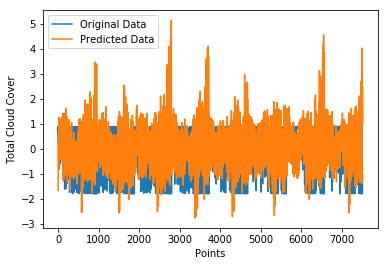

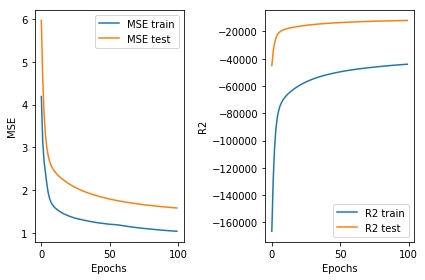

In [18]:
with tf.Session() as sess:
    # Initiate session and initialize all vaiables
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    c_t = []
    c_test = []
    r2_t = []
    r2_test = []
    for i in range(100):        
        sess.run([cost,train],feed_dict=    {xs:Xn_train, ys:yn_train})
        
        c_t.append(sess.run(cost, feed_dict={xs:Xn_train,ys:yn_train}))
        c_test.append(sess.run(cost, feed_dict={xs:Xn_test,ys:yn_test}))
        print('Epoch :',i,'Cost train:',c_t[-1], 'Cost test:',c_test[-1])
        r2_t.append(sess.run(R_squared, feed_dict={xs:Xn_train,ys:yn_train}))
        r2_test.append(sess.run(R_squared, feed_dict={xs:Xn_test,ys:yn_test}))
        print('Epoch :',i,'R2 train:',r2_t[-1], 'R2 test:',r2_test[-1])
    
    pred = sess.run(output, feed_dict={xs:Xn_test})
    # predict output of test data after training
    print('Cost :',sess.run(cost, feed_dict={xs:Xn_test,ys:yn_test}))

    plt.plot(range(yn_test.shape[0]),yn_test,label="Original Data")
    plt.plot(range(yn_test.shape[0]),pred,label="Predicted Data")
    plt.legend(loc='best')
    plt.ylabel('Total Cloud Cover')
    plt.xlabel('Points')
    #plt.title('Total Cloud Cover')
    plt.savefig('results/data_t0_2layers_10_10_split03.png')
    plt.show()
    
    
    plt.subplot(1,2,1)
    plt.plot(range(len(c_t)), c_t,label="MSE train")
    plt.plot(range(len(c_test)), c_test,label="MSE test")
    plt.legend(loc='best')
    plt.ylabel('MSE')
    plt.xlabel('Epochs')
    #plt.title('Cost vs. epochs')
    plt.tight_layout()
    
    plt.subplot(1,2,2)
    plt.plot(range(len(r2_t)), r2_t,label="R2 train")
    plt.plot(range(len(r2_test)), r2_test,label="R2 test")
    plt.legend(loc='best')
    plt.ylabel('R2')
    plt.xlabel('Epochs')
    #plt.title('R2 vs. epochs')
    plt.tight_layout()
    plt.savefig('results/t0_2layers_10_10_split03.png')
    plt.show()
    
  